## German Traffic Sign MultiClass Classification

### Download the german traffic sign dataset

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs 
!ls german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.
signnames.csv  test.p  train.p	valid.p


### import libraries for loading data, creating and training CNN model, display images and plotting data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import random
import cv2
import pickle 
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


### Load the train, test and validation data

In [3]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
    
print(train_data.keys())

X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

dict_keys(['coords', 'features', 'sizes', 'labels'])
(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


### Visualize 5 images per class, record total number of images per class available in the dataset

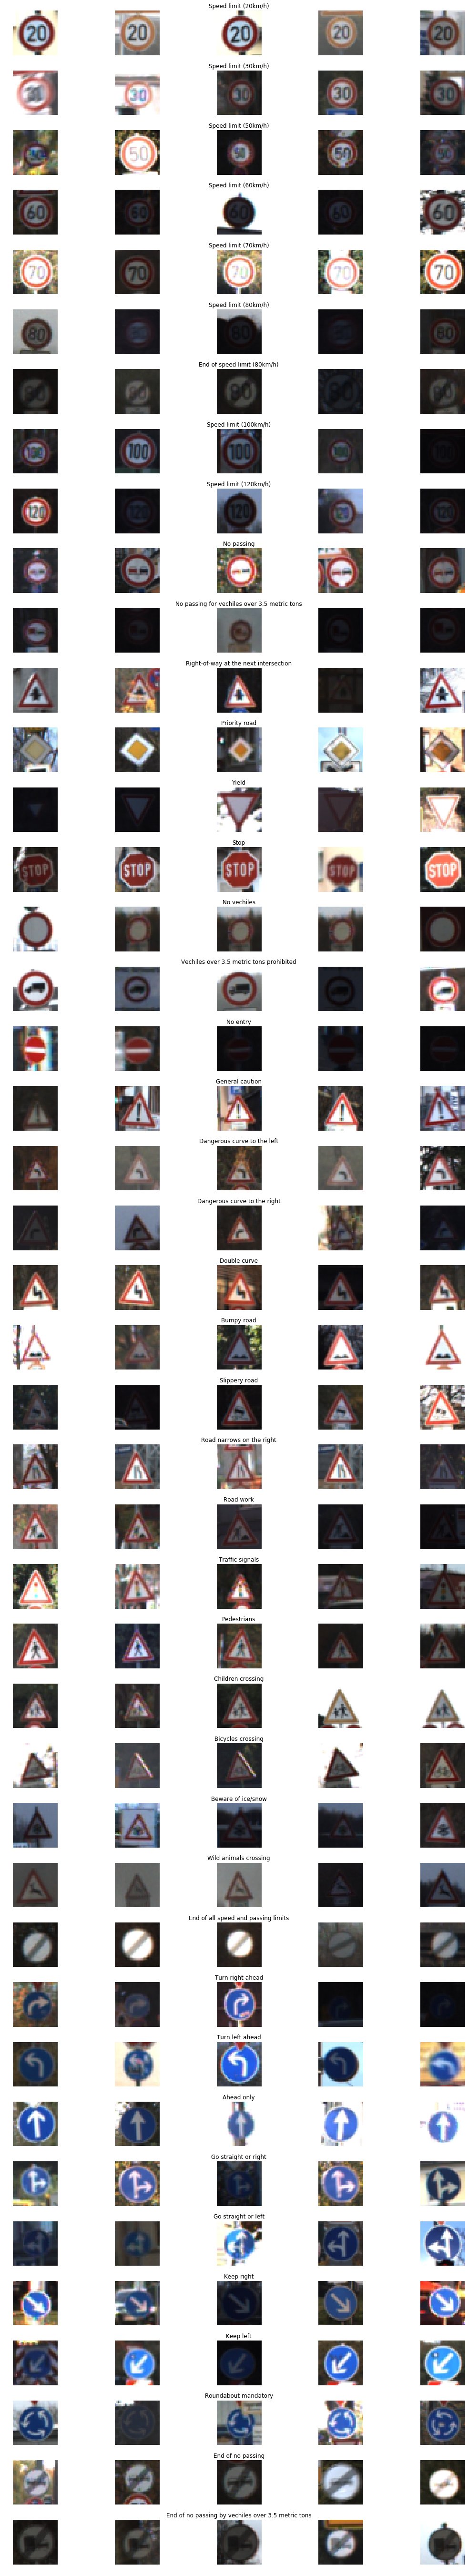

In [4]:
sign_data = pd.read_csv('german-traffic-signs/signnames.csv')
num_samples = []
n_classes=43
fig, ax = plt.subplots(nrows=n_classes, ncols = 5, figsize=(15,75))
fig.tight_layout()
class_id = range(n_classes)
sign_names = []
for i, rows in sign_data.iterrows():
    sign_names.append(rows['SignName'])
    imgs = X_train[y_train==rows['ClassId']]
    num_samples.append(len(imgs))
    for j in range(5):
        ax[rows['ClassId'],j].imshow(imgs[random.randint(0,len(imgs)-1), :, :, :])
        ax[rows['ClassId'],j].axis('off')
        if j==2:
            ax[rows['ClassId'],j].set_title(str(rows['SignName']))
fig.savefig('images/signnames_samples.jpg')
    

### Plot the distribution of number of samples per class

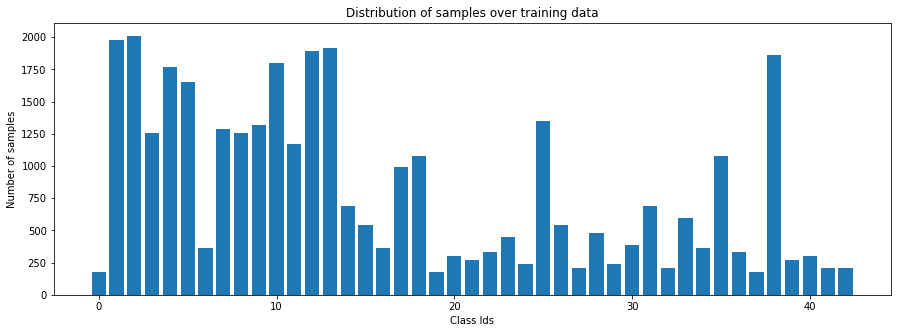

In [5]:
fig = plt.figure(figsize=(15,5))
plt.bar(range(n_classes), num_samples)
plt.title('Distribution of samples over training data')
plt.xlabel('Class Ids')
plt.ylabel('Number of samples')
fig.savefig('images/Dist_of_sample.jpg')

### Preprocess all the images. Convert to grayscale, histogram equilization and normalization of pixel values.

In [7]:
def cvtGray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def histogramEqua(img):
    return cv2.equalizeHist(img)

def preProcessImage(img):
    img = histogramEqua(cvtGray(img))
    return img/255

X_train_pro = np.array(list(map(preProcessImage, X_train)))
X_test_pro = np.array(list(map(preProcessImage, X_test)))
X_val_pro = np.array(list(map(preProcessImage, X_val)))

X_train_pro = X_train_pro.reshape(X_train.shape[0], 32,32,1)
X_test_pro = X_test_pro.reshape(X_test.shape[0], 32,32,1)
X_val_pro = X_val_pro.reshape(X_val.shape[0], 32,32,1)

y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)
y_val_cat = to_categorical(y_val, n_classes)

print(X_train_pro.shape)
print(X_test_pro.shape)
print(X_val_pro.shape)

print(y_train_cat.shape)
print(y_test_cat.shape)
print(y_val_cat.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)
(34799, 43)
(12630, 43)
(4410, 43)


### Augment the dataset using ImageDataGenerator. Visualize sample batch set of 10 images.

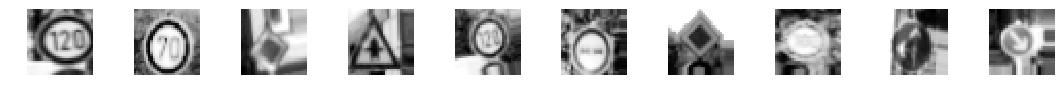

In [18]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
                            rotation_range=10, zoom_range=0.2)

batches = datagen.flow(X_train_pro, y_train, batch_size=10)
x_train_sample, y_train_sample = next(batches)

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,5))
fig.tight_layout()
for i in range(10):
    ax[i].imshow(x_train_sample[i,:,:,0], cmap=plt.get_cmap('gray'))
    ax[i].axis('off')
fig.savefig('images/Preprocessed_samples.jpg')

### Create CNN Model for training.

In [9]:
def model():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(32,32,1)))
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=n_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])
    print(model.summary())
    return model
model = model()    






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
____________________

### Train the model using fit_generator to train on the batch of data generated using ImageDataGenerator

In [10]:
h = model.fit_generator(datagen.flow(X_train_pro, y_train_cat, batch_size=50), steps_per_epoch=2000,
                       epochs=5, validation_data=(X_val_pro, y_val_cat), verbose=1, shuffle='true')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





2000/2000 [==============================] - 53s 26ms/step - loss: 0.9057 - acc: 0.7358 - val_loss: 0.1068 - val_acc: 0.9687
Epoch 2/5
2000/2000 [==============================] - 30s 15ms/step - loss: 0.2216 - acc: 0.9315 - val_loss: 0.0550 - val_acc: 0.9857
Epoch 3/5
2000/2000 [==============================] - 29s 15ms/step - loss: 0.1493 - acc: 0.9537 - val_loss: 0.0488 - val_acc: 0.9862
Epoch 4/5
2000/2000 [==============================] - 29s 15ms/step - loss: 0.1100 - acc: 0.9658 - val_loss: 0.0517 - val_acc: 0.9853
Epoch 5/5
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0952 - acc: 0.9710 - val_loss: 0.0434 - val_acc: 0.9859


### Plot model training performance history 

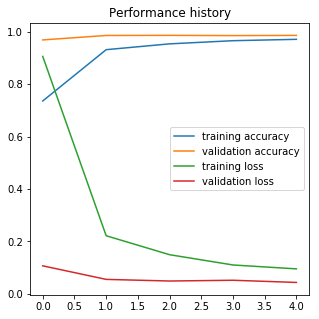

In [20]:
fig = plt.figure(figsize=(5,5))
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Performance history')
plt.legend(['training accuracy','validation accuracy','training loss','validation loss'])
fig.savefig('images/Performance history')

### Evaluate model performance on the test dataset

In [12]:
print(model.evaluate(X_test_pro, y_test_cat, verbose=1))

12630/12630 [==============================] - 2s 155us/step
[0.09167399509031597, 0.9728424386098473]


### Download a sample using url of the image. Visualize, preprocess the image and run the classification model on the image

Recognized Class ID:  29  Sign Name:  Bicycles crossing


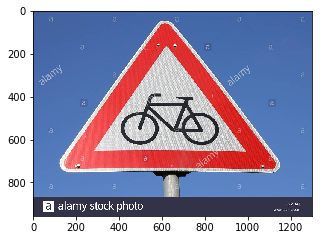

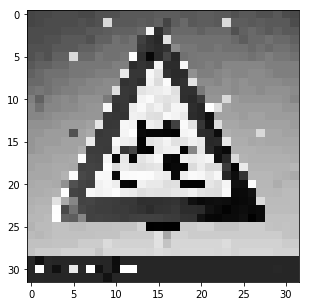

In [14]:
import requests
from PIL import Image
      
url='https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
response = requests.get(url, stream='True')
img = Image.open(response.raw)
plt.figure(figsize=(5,5))
plt.imshow(img)

img = np.asarray(img)
img = cv2.resize(img, (32,32))
img = preProcessImage(img)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap=plt.get_cmap('gray'))
img = img.reshape(1,32,32,1)
id = model.predict_classes(img)
print('Recognized Class ID: ', id[0], ' Sign Name: ', sign_names[id[0]])